In [117]:
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns


In [118]:
df = pd.read_csv("Rice_data_type.csv")
df=df.drop("Unnamed: 0",axis = 1)
data = df.to_numpy()
x = df.loc[:,df.columns!="Class"].to_numpy()
y = df["Class"].to_numpy()

y = np.array([0 if y_ == "b'Cammeo'"  else 1 for y_ in y])

print(x.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(x, y,random_state=42)
poly = PolynomialFeatures(3)
X_tr_poly = poly.fit_transform(X_train) # transforms the training data
X_val_poly = poly.transform(X_test) # transforms the validation data

X_train = X_tr_poly
X_test = X_val_poly
print(X_train.shape)
train_error_c = []
validation_error_c = []

(3810, 7) (3810,)
(2857, 120)


In [119]:
feature = 3
r = "lasso"

In [120]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
X_train_transformed=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
# Reshape `y_train` into 2D array, and `y_test` into 2D array 
y_2d_train = y_train.reshape(y_train.shape[0],1)
y_2d_test = y_test.reshape(y_test.shape[0],1)


print(X_train_transformed.shape,X_test.shape,y_2d_train.shape,y_2d_test.shape)

(2857, 120) (953, 120) (2857, 1) (953, 1)


In [121]:
ones = np.ones((X_train.shape[0],1))
X_train_1 = np.hstack((ones,X_train_transformed))


In [122]:
def sigmoid(z):
    z = z.astype(np.float64)
    return 1/(1+np.exp(-z))

In [123]:
w_init = np.zeros(((X_train_1.shape[1],1)))

In [124]:
def hypothesis(X, w):
    return sigmoid(X.dot(w))

In [125]:
def log_likelihood(X, y, w):
    return np.mean(y*np.log(hypothesis(X,w))+(1-y)*np.log(1-hypothesis(X,w)))

In [126]:
def cross_entropy_loss(X,y,w):
    return -(log_likelihood(X,y,w))

In [127]:
def ridge(w,c):
    I = np.identity(w.shape[0])
    I[0][0]=0
    return -c*I.dot(w)

In [128]:
def lasso(w,c):
    I = np.zeros(len(w)).reshape(-1,1)
    I[0]=0
    for i in range(1,len(w)):
        if(w[i]>0):
            I[i]= 1
        elif w[i]<0:
            I[i]= -1 
        else:
            I[i]=0
    return -c*I

In [129]:
def Gradient_Ascent(X, y, learning_rate, num_iters,c):
    # We assume X has been augmented with a column of ones
    
    # Number of training examples.
    N = X.shape[0]
    parameters = []
    # Initialize w(<np.ndarray>). Zeros vector of shape X.shape[1],1
    w = np.zeros((X.shape[1],1))
    # Initiating list to store values of likelihood(<list>) after few iterations.
    log_likelihood_values = []
    loss = []
    # Gradient Ascent - local optimization technique
    for i in range(num_iters):
        gradient = X.T.dot(y-hypothesis(X,w))
        w=w+learning_rate/N*gradient+lasso(w,c)
        
        # Computing log likelihood of seeing examples for current value of w
        if (i % 10) == 0:
            log_likelihood_values.append(log_likelihood(X, y, w))
            loss.append(-log_likelihood(X, y, w))
            parameters.append(w)
            #print(log_likelihood(X, y, w))
    
    return w, log_likelihood_values,loss,parameters

In [130]:
def predict_class(X, w, t):
    predict = hypothesis(X,w)

    return np.array([0 if prediction_case < t else 1 for prediction_case in predict]).reshape(X.shape[0],1)

In [131]:
def accuracy(X,y,w):
    predict = predict_class(X,w,0.5)
    
    return np.sum([1 if predict[i]==y[i] else 0 for i in range(len(y))])/(predict.shape[0])


In [132]:
ones = np.ones((X_test.shape[0],1))
X_test_1 = np.hstack((ones,X_test))
learning_rate = 0.1
num_iters = 300
c = [0.00001,0.0001,0.001,0.01,0.1]
w_c = []
log_c = []
loss_c = []
para_c = []
train_accuracy = []
valid_accuracy = []
# Calculate w and likelihood values using Gradient_Ascent with X_train_1, y_2d_train
for i in c:
    w, log_likelihood_values,loss_values,parameters = Gradient_Ascent(X_train_1, y_2d_train, learning_rate, num_iters,i)
    w_c.append(w)
    print(w.shape)
    log_c.append(log_likelihood_values)
    loss_c.append(loss_values)
    para_c.append(parameters)
    train_accuracy.append(accuracy(X_train_1,y_2d_train,w))
    valid_accuracy.append(accuracy(X_test_1,y_2d_test,w))
    train_error_c.append(loss_values[-1])



(121, 1)
(121, 1)
(121, 1)
(121, 1)
(121, 1)


In [133]:

# Now predict the label of each example in your test set
y_hat = []
for i in w_c:
    y_hat.append(predict_class(X_test_1,i,0.5))


In [134]:
# Write the precision_recall function by first calculating: false_pos, false_neg and true_pos.  Using these numbers compute the precision and recall
def precision_recall(y_hat, y, threshold):  
    y_pred = (y_hat > threshold).astype(int)
    
    # Calculate true positives, false positives, false negatives, and true negatives
    TP = np.sum((y == 1) & (y_pred == 1))
    FP = np.sum((y == 0) & (y_pred == 1))
    FN = np.sum((y == 1) & (y_pred == 0))
    TN = np.sum((y == 0) & (y_pred == 0))
    
    # Calculate precision and recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    return precision, recall
    '''
    # Calculate false positive and false negative
    # HINT: if done correctly, false_pos should be 1 and false_neg should be 1
    false_pos = np.sum(y_hat>y)
    false_neg = np.sum(y_hat<y)
    
    # Calculate true positive and true negatives
    # HINT: if done correctly, true_pos should be 88
    true_pos = 0
    for i in range((y.shape[0])):
        if y[i]==y_hat[i]:
            if y[i]==1:
                true_pos +=1
        
    #print(false_pos,false_neg,true_pos)
    if(true_pos==0):
        print(y_hat)
        print(y)
    precision = true_pos/(true_pos+false_pos)
    recall = true_pos/(true_pos+false_neg)
    return precision,recall
    '''

In [135]:
def f1_score(precision, recall):
    
    return 2*precision*recall/(precision+recall) if (precision + recall) > 0 else 0

In [136]:
precisions = []
recalls = []
f1s = []
for i in y_hat:
    precision, recall = precision_recall(i,y_2d_test,0.5)
    recalls.append(recall)
    precisions.append(precision)
    f1s.append(f1_score(precision, recall))



In [137]:
#validation
validation_loss_c = []
for paremters in para_c:
    validation_loss = []
    for para in parameters:
        validation_loss.append(cross_entropy_loss(X_test_1,y_2d_test,para))
    validation_loss_c.append(validation_loss)
    validation_error_c.append(validation_loss[-1])


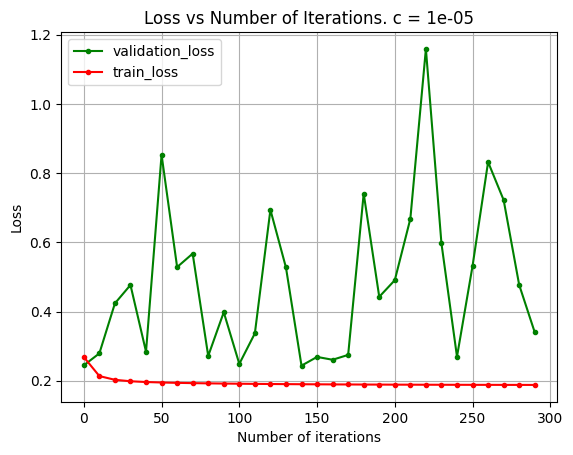

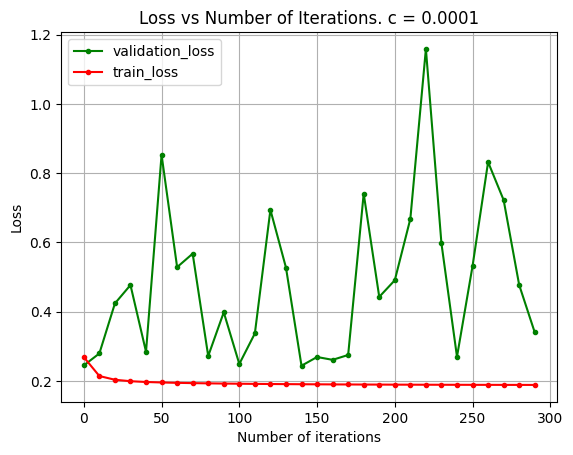

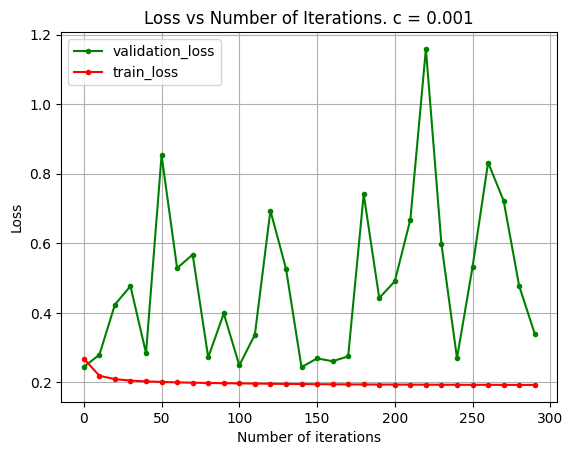

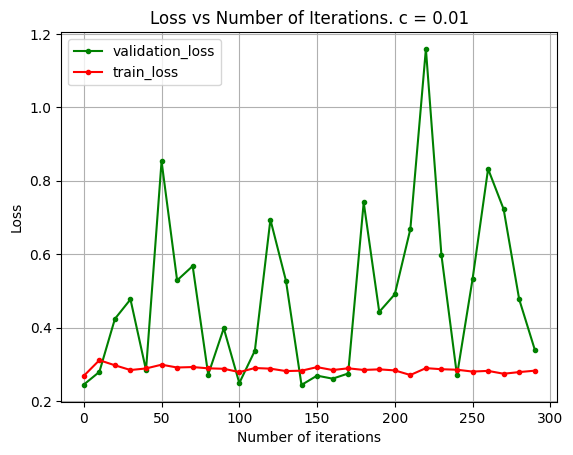

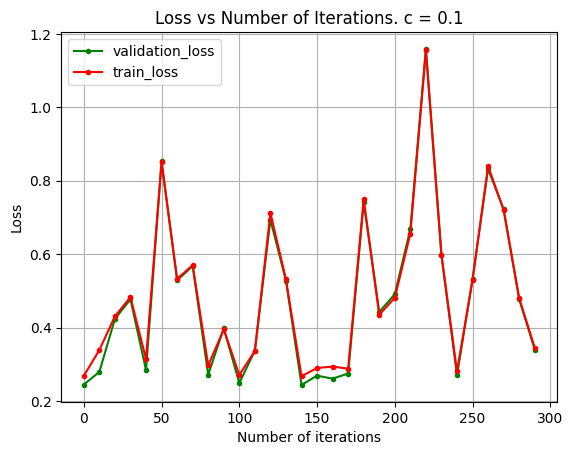

In [138]:
iters = np.array(range(0,num_iters,10))
for i in range(len(validation_loss_c)):
    plt.plot(iters,validation_loss_c[i],'.-',color='green',label = "validation_loss")
    plt.plot(iters,loss_c[i],'.-',color='red',label = "train_loss")
    plt.legend()
    plt.xlabel('Number of iterations')
    plt.ylabel('Loss')
    plt.title("Loss vs Number of Iterations. c = {}".format(str(c[i])))
    plt.grid()
    #plt.savefig('{} {} {}.png'.format(feature,r,str(c[i])))
    plt.show(block=False)
    plt.close()

[0.9295774647887324, 0.9295774647887324, 0.933806146572104, 0.9645569620253165, 0.946949602122016] [0.9209302325581395, 0.9209302325581395, 0.9186046511627907, 0.8860465116279069, 0.8302325581395349] [0.9252336448598131, 0.9252336448598131, 0.9261430246189918, 0.9236363636363637, 0.8847583643122676]


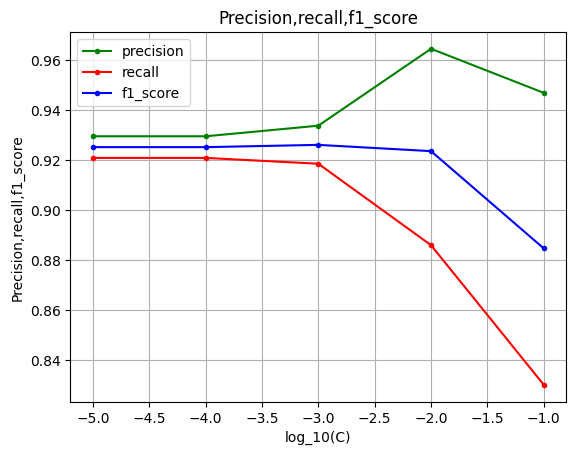

[0.9295774647887324, 0.9295774647887324, 0.933806146572104, 0.9645569620253165, 0.946949602122016] [0.9209302325581395, 0.9209302325581395, 0.9186046511627907, 0.8860465116279069, 0.8302325581395349] [0.9252336448598131, 0.9252336448598131, 0.9261430246189918, 0.9236363636363637, 0.8847583643122676]


In [139]:
f1 = np.array(np.log10(c))
print(precisions,recalls,f1s)

plt.plot(f1,precisions,'.-',color='green')
plt.plot(f1,recalls,'.-',color='red')
plt.plot(f1,f1s,'.-',color='blue')
plt.plot()
plt.xlabel('log_10(C)')
plt.ylabel('Precision,recall,f1_score')
plt.title('Precision,recall,f1_score')
plt.grid()

plt.gca().legend(("precision",'recall',"f1_score"))
#plt.savefig('{} {} f1.png'.format(feature,r))
plt.show(block=False)
plt.close()
print(precisions,recalls,f1s)

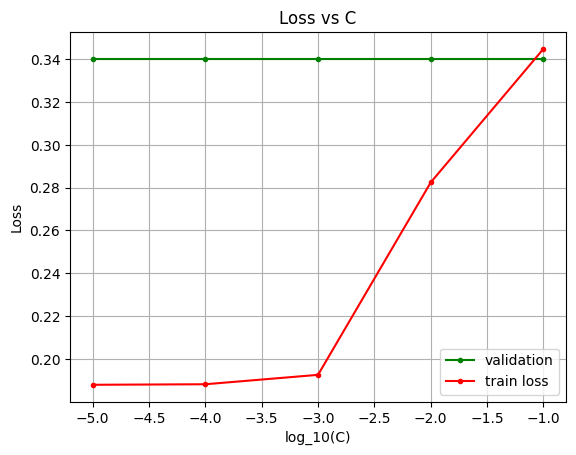

[0.9295774647887324, 0.9295774647887324, 0.933806146572104, 0.9645569620253165, 0.946949602122016] [0.9209302325581395, 0.9209302325581395, 0.9186046511627907, 0.8860465116279069, 0.8302325581395349] [0.9252336448598131, 0.9252336448598131, 0.9261430246189918, 0.9236363636363637, 0.8847583643122676]


In [140]:

plt.plot(f1,[i[-1] for i in validation_loss_c],'.-',color='green')
plt.plot(f1,[i[-1] for i in loss_c],'.-',color='red')
plt.plot()
plt.xlabel('log_10(C)')
plt.ylabel('Loss')
plt.title('Loss vs C')
plt.grid(True)

plt.gca().legend(("validation","train loss"))
#plt.savefig('{} {} loss_c.png'.format(feature,r))
plt.show(block=False)
plt.close()
print(precisions,recalls,f1s)

In [141]:
print(train_accuracy)
print(valid_accuracy)

[0.9268463423171158, 0.9261463073153657, 0.9257962898144907, 0.9177458872943647, 0.8991949597479874]
[0.9328436516264428, 0.9328436516264428, 0.9338929695697796, 0.9338929695697796, 0.9024134312696747]


In [142]:
'''
c = [0.00001,0.0001,0.001,0.01,0.1]

'''

'\nc = [0.00001,0.0001,0.001,0.01,0.1]\n\n'

In [143]:
print(train_error_c)
print(validation_error_c)
plt.plot(f1,train_error_c,'.-',color='green')
plt.plot(f1,validation_error_c,'.-',color='red')

plt.savefig('{} {} loss vs C.png'.format(feature,r))
plt.xlabel('loss vs C')
plt.ylabel('Loss')
plt.title('Loss vs C')

plt.close()




[0.18794620640807377, 0.1881938575437402, 0.19258410627863645, 0.2824320131141145, 0.344809247316524]
[0.3400536651787907, 0.3400536651787907, 0.3400536651787907, 0.3400536651787907, 0.3400536651787907]


In [144]:

w_heat = np.array(w_c)
print(len(w_c))
w_c = w_heat.reshape(5,len(w_c[0]))

5


[[-5.04710605e-01  0.00000000e+00  6.33201496e-03  5.51211334e-02
   9.43453689e-02 -1.21341661e-01  1.58199401e-01  3.28419628e-02
  -2.03498869e-02  3.28564704e-02  4.20028456e-02  6.12792321e-02
  -1.87107957e-02  3.40596963e-02  4.57430893e-02 -6.30615091e-03
   6.85932689e-02  9.16377097e-02 -1.73391442e-02  9.05800974e-02
   5.87347772e-02  6.39658557e-03  1.09850147e-01  1.15109226e-02
   1.17229648e-01  7.75505196e-02  3.41988471e-02 -1.10684702e-01
  -6.76832403e-02 -9.31077202e-04 -6.95195099e-02  1.62091654e-01
   5.90137904e-02  3.17054362e-03  5.85430448e-02  9.63577229e-03
  -2.11929041e-02  5.81715499e-02  5.89538466e-02  7.14170415e-02
   1.96861006e-02  4.74409782e-02  6.63676773e-02  2.12136572e-02
   6.54309337e-02  7.99913518e-02  1.78115753e-02  5.97312604e-02
   6.87970815e-02  2.39424768e-02  9.29554053e-02  3.50120974e-02
   7.70212511e-02  8.11886506e-02  4.08646481e-02 -2.80118660e-02
  -1.56759791e-03  2.99694159e-02 -2.32189183e-02  5.79316607e-02
   6.00442

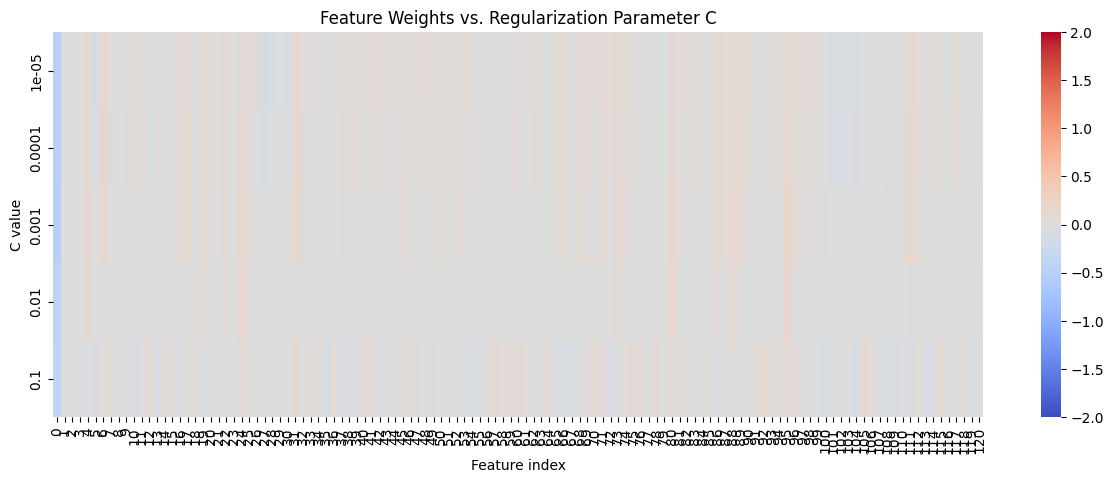

In [145]:
weights_array = np.array(w_heat).reshape(5,-1)
print(weights_array)
plt.figure(figsize=(15, 5))
sns.heatmap(weights_array,annot_kws={"size":10},annot=False,cmap='coolwarm', fmt=".2f", vmin = -2, vmax = 2, center = 0,xticklabels=range(weights_array.shape[1]), yticklabels=c)
plt.title('Feature Weights vs. Regularization Parameter C')
plt.xlabel('Feature index')
plt.ylabel('C value')
plt.savefig('{} {} heatmap.png'.format(feature,r))
plt.show()
plt.close()
